# Predcition of Hospital Admission Related to Sinusitis

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sinusitis. We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import scipy.stats as st
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'sinusitis_date_'+str(i), 'sinusitis_ab_date_'+str(i), 'sinusitis_ab_type_'+str(i),
                   'incdt_sinusitis_date_'+str(i), 'admitted_sinusitis_date_'+str(i), 'sgss_gp_cov_sinusitis_date_'+str(i)]]
    
    #drop rows with no sinusitis reord
    datum = datum[datum['sinusitis_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with sinusitis_i
    datum = datum[datum['sgss_gp_cov_sinusitis_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'sinusitis_date_'+str(i): 'sinusitis_date', 'sinusitis_ab_date_'+str(i): 'sinusitis_ab_date', 
                           'sinusitis_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_sinusitis_date_'+str(i): 'incdt_sinusitis_date', 'incdt_sinusitis_type_'+str(i): 'incdt_sinusitis_type',
                           'admitted_sinusitis_date_'+str(i): 'admitted_sinusitis_date',
                           'sgss_gp_cov_sinusitis_date_'+str(i): 'sgss_gp_cov_sinusitis_date'},
                inplace=True)
    
    return datum

In [5]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [6]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_sinusitis_admitted',
            event_col='event_sinusitis_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_sinusitis_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a columns of risk factors, prescribed antibiotics, and hosp event 
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary', 'event_'+infection+'_admitted']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count', 'event_'+infection+'_admitted_mean', 'event_'+infection+'_admitted_sum', 'event_'+infection+'_admitted_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)

    #save prob_pred for analysis in r
    prob_pred.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis.csv', index=False)

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    #save prob_pred_enc_lr_rf for analysis in r
    prob_pred_enc_lr_rf.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis_binned.csv', index=False)

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier()#n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #caculate ORs and intervals of LR model, save and print them 
    # lr_coef = pd.DataFrame({"or": lr.coef_})#, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef_exp = np.exp(lr_coef)
    # lr_coef_exp.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    # lr_coef = lr.coef_
    # print('LR ORs:\n %s'%(lr_coef))
    # lr_coef = pd.DataFrame(data=np.exp(lr.coef_), index=data_enc_dev_x.columns, columns=['lr_coef'])
    # lr_coef = lr_coef.sort_values('lr_coef', ascending=False)
    # lr_coef = pd.DataFrame(data=lr.coef_.T, index=data_enc_dev_x.columns, columns=['lr_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # # lr_coef['lr_coef_lower_bound'] = st.norm.ppf(lr_coef['lr_coef'])
    
    # alpha = 0.05
    # #the coefficients of the regression model
    # coefs = np.r_[lr.coef_.T.tolist()]#[lr.intercept_], lr.coef_.T.tolist()
    # #build an auxiliary dataframe with the constant term in it
    # X_aux = data_enc_dev_x.copy()
    # # X_aux.insert(0, 'const', 1)
    # #degrees of freedom
    # dof = -np.diff(X_aux.shape)[0]
    # #Student's t-distribution table lookup
    # t_val = stats.t.isf(alpha/2, dof)
    # #MSE of the residuals
    # mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
    # #inverse of the variance of the parameters
    # var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    # #distance between lower and upper bound of CI
    # gap = t_val * np.sqrt(mse * var_params)
    # lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
    # lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
    # # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
    # lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # rf_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR model with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [9]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    # #print summary of LR model
    # lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef = np.exp(lr_coef)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    # print('LR coefficients:\n %s'%(lr_coef))
    
#     alpha = 0.05
#     #the coefficients of the regression model
#     coefs = np.r_[lr.coef_.T.tolist()] #[lr.intercept_], lr.coef_.T.tolist()
#     #build an auxiliary dataframe with the constant term in it
#     X_aux = data_enc_dev_x.copy()
#    #  X_aux.insert(0, 'const', 1)
#     #degrees of freedom
#     dof = -np.diff(X_aux.shape)[0]
#     #Student's t-distribution table lookup
#     t_val = stats.t.isf(alpha/2, dof)
#     #MSE of the residuals
#     mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
#     #inverse of the variance of the parameters
#     var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
#     #distance between lower and upper bound of CI
#     gap = t_val * np.sqrt(mse * var_params)
#     lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
#     lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
#     # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
#     lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [ ]:
#bootstrap and create lr models
def lr_bootstrap(data):
    sample = data.sample(data.shape[0], replace=True)
    X_tr = sample[[c for c in sample.columns if c != 'ab_binary']]
    y_tr = sample.ab_binary
    lr = LogisticRegression().fit(X_tr, y_tr)
    params = list(lr.coef_[0]) 

    return params

In [ ]:
#calculate mean and standard error of lr models with bootstraped data to calculate mean coeffients and intervals of coefficients and odds ratios and their intervals
def get_lr_betas_intervals(data):
    #get column names of inputs
    data_x_columns = data.drop('ab_binary', axis=1).columns
    #create lr models with bootstraped samples for 100 times
    params_samples = pd.DataFrame([lr_bootstrap(data) for _ in range(100)])
    #calculate mean and standard error for coefficients of lrs with samples
    coefs_mean = params_samples.mean()
    coefs_se = params_samples.std()
    z_val = stats.norm.ppf(0.975)
    coefs_se_z_val = coefs_se * z_val
    #create a table of coefficients and their intervals for covariates 
    lr_summary = pd.DataFrame({'covariate': data_x_columns.tolist(), 'coef': coefs_mean, 'coef_lower_95%': coefs_mean - coefs_se_z_val, 'coef_upper_95%': coefs_mean + coefs_se_z_val})
    #clculate odds ratios and their intervals for covariates
    lr_summary[['or', 'or_lower_95%', 'or_upper_95%']] = np.exp(lr_summary[['coef', 'coef_lower_95%', 'coef_upper_95%']])

    return lr_summary

In [10]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val):#, rf_pred_dev, rf_pred_val):
    # ##calibration for RF
    # rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    # #
    # rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    # #plot calibration plot for RF model with development and validation data
    # fig, ax1 = plt.subplots(figsize=(7, 7))
    # plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    # plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    # plt.xlabel('Mean predicted probabilities', fontsize=14)
    # plt.ylabel('Proportion of observed values', fontsize=14)
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=12, rotation=0)
    # plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    # plt.title("Calibration plot of RF model", fontsize=14)
    # legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    # legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    # plt.legend(handles=[legend_dev, legend_val])
    # plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    # plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [11]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_sinusitis.csv.gz')

In [12]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [13]:
#process 20 sinusitiss and concatenate them 
data_sinusitis_1 = proc_infec_data(data,1)
data_sinusitis_2 = proc_infec_data(data,2)
data_sinusitis_3 = proc_infec_data(data,3)
data_sinusitis_4 = proc_infec_data(data,4)
data_sinusitis_5 = proc_infec_data(data,5)
data_sinusitis_6 = proc_infec_data(data,6)
data_sinusitis_7 = proc_infec_data(data,7)
data_sinusitis_8 = proc_infec_data(data,8)
data_sinusitis_9 = proc_infec_data(data,9)
data_sinusitis_10 = proc_infec_data(data,10)
data_sinusitis_11 = proc_infec_data(data,11)
data_sinusitis_12 = proc_infec_data(data,12)
data_sinusitis_13 = proc_infec_data(data,13)
data_sinusitis_14 = proc_infec_data(data,14)
data_sinusitis_15 = proc_infec_data(data,15)
data_sinusitis_16 = proc_infec_data(data,16)
data_sinusitis_17 = proc_infec_data(data,17)
data_sinusitis_18 = proc_infec_data(data,18)
data_sinusitis_19 = proc_infec_data(data,19)
data_sinusitis_20 = proc_infec_data(data,20)

data_sinusitis = pd.concat([data_sinusitis_1, data_sinusitis_2, data_sinusitis_3, data_sinusitis_4, data_sinusitis_5, data_sinusitis_6, data_sinusitis_7, data_sinusitis_8, data_sinusitis_9, data_sinusitis_10, data_sinusitis_11, data_sinusitis_12, data_sinusitis_13, data_sinusitis_14, data_sinusitis_15, data_sinusitis_16, data_sinusitis_17, data_sinusitis_18, data_sinusitis_19, data_sinusitis_20])
data_sinusitis.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [14]:
##add variable season
#convert data types
data_sinusitis['sinusitis_date'] = data_sinusitis['sinusitis_date'].astype('datetime64[ns]')
data_sinusitis['admitted_sinusitis_date'] = data_sinusitis['admitted_sinusitis_date'].astype('datetime64[ns]')
data_sinusitis.died_date = data_sinusitis.died_date.astype('datetime64[ns]')
data_sinusitis.deregistered_date = data_sinusitis.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_sinusitis['date'] = data_sinusitis['sinusitis_date'] 
data_sinusitis['date'] = data_sinusitis['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_sinusitis with today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_1_month_date_y_m]
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of sinusitis records
data_sinusitis['season'] = np.nan
data_sinusitis['date_month'] = pd.DatetimeIndex(data_sinusitis['date']).month

conditions = [
    (data_sinusitis['date_month'] >= 3) & (data_sinusitis['date_month'] <= 5),
    (data_sinusitis['date_month'] >= 6) & (data_sinusitis['date_month'] <= 8),
    (data_sinusitis['date_month'] >= 9) & (data_sinusitis['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_sinusitis['season'] = np.select(conditions, choices, default='winter')

In [15]:
#add variable time period
data_sinusitis.loc[(data_sinusitis['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_sinusitis.loc[((data_sinusitis['date'] >= '2020-05') & (data_sinusitis['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_sinusitis.loc[(data_sinusitis['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

In [16]:
data_sinusitis['date'].max()

'2023-04'

#### event and duration

In [17]:
#scenario 1
#not hosped (nothing happened)
data_sinusitis.loc[data_sinusitis['admitted_sinusitis_date'].isnull(), 'event_sinusitis_admitted'] = 0

In [18]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_sinusitis['delta_sinusitis_admitted'] = (data_sinusitis['admitted_sinusitis_date'] - data_sinusitis['sinusitis_date']).dt.days
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] >= 0) & (data_sinusitis['delta_sinusitis_admitted'] <= 30)), 'event_sinusitis_admitted'] = 1

#scenario 2
#drop whoever was admitted before sinusitis consultation, i.e. negative value for delta_sinusitis_admitted
data_sinusitis = data_sinusitis[~(data_sinusitis['delta_sinusitis_admitted'] < 0)]

In [19]:
#scenario 3
#censor died patients
data_sinusitis['delta_admitted_died'] = (data_sinusitis['died_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_sinusitis.loc[((data_sinusitis['delta_admitted_died'] >= 0) & (data_sinusitis['delta_admitted_died'] <= 30)), 'event_sinusitis_admitted'] = 0

#scenario 3
#censor deregistered patients
data_sinusitis['delta_admitted_deregistered'] = (data_sinusitis['deregistered_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_sinusitis.loc[((data_sinusitis['delta_admitted_deregistered'] > 0) & (data_sinusitis['delta_admitted_deregistered'] <= 30)), 'event_sinusitis_admitted'] = 0

#agg scenario 3s
data_sinusitis['delta_admitted_died_deregistered'] = data_sinusitis['delta_admitted_deregistered'].combine_first(data_sinusitis['delta_admitted_died'])
data_sinusitis.loc[data_sinusitis['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [20]:
#scenario 1
#any other patients (nothing happened)
data_sinusitis['event_sinusitis_admitted'] = data_sinusitis['event_sinusitis_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['delta_sinusitis_admitted'].combine_first(data_sinusitis['delta_admitted_died_deregistered'])
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['duration_sinusitis_admitted'].replace(np.NaN, 30)
data_sinusitis.loc[(data_sinusitis['duration_sinusitis_admitted'] > 30), 'duration_sinusitis_admitted'] = 30

#give value 1 to event_sinusitis_admitted if duration_sinusitis_admitted is greater or equal to 0 and less than 30
data_sinusitis.loc[((data_sinusitis['duration_sinusitis_admitted'] >= 0) & (data_sinusitis['duration_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

#drop any rows with value 0 in duration column
data_sinusitis = data_sinusitis[~(data_sinusitis['duration_sinusitis_admitted'] == 0)]

In [21]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] > 0) & (data_sinusitis['delta_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [22]:
#drop anybody with age less than 18 or 0!
data_sinusitis = data_sinusitis[~(data_sinusitis['age'] < 18)] 
data_sinusitis['age'][data_sinusitis['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '0-4']
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_sinusitis['bmi'][data_sinusitis['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_sinusitis['bmi'] = data_sinusitis['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_sinusitis['antibacterial_brit'][data_sinusitis['antibacterial_brit'] < 0] = np.nan

In [23]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"smoking": dict_smoking})

In [24]:
#drop rows with missing region
if ('region' in data_sinusitis.columns) and (data_sinusitis['region'].isnull().sum() > 0):
   data_sinusitis = data_sinusitis[data_sinusitis['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_sinusitis.columns) and (data_sinusitis['antibacterial_brit'].isnull().sum() > 0):
    data_sinusitis['antibacterial_brit'] = data_sinusitis['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_sinusitis.columns) and (data_sinusitis['ethnicity'].isnull().sum() > 0):
    data_sinusitis['ethnicity'] = data_sinusitis['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_sinusitis.columns) and (data_sinusitis['smoking'].isnull().sum() > 0):
    data_sinusitis['smoking'] = data_sinusitis['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_sinusitis.columns) and (data_sinusitis['imd'].isnull().sum() > 0):
    data_sinusitis['imd'] = data_sinusitis['imd'].fillna(0)

In [25]:
#missing values of bmi assign 5 and 0; categorise bmi
data_sinusitis['bmi_cat'] = 5

for idx, x in enumerate(data_sinusitis['bmi_cat']):
    if data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 30:
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 25) and (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 30):
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 18.5) and (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 25):
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 18.5:
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_sinusitis.columns) and (data_sinusitis['bmi_cat'].isnull().sum() > 0):
    data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].fillna(0)

In [26]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_sinusitis.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_sinusitis['ab_type_cat'] = np.where(data_sinusitis['ab_type'].isin(ab_series[mask].index),'other',data_sinusitis['ab_type'])
#assign no to non ab users
data_sinusitis.loc[data_sinusitis['sinusitis_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_sinusitis['ab_type_cat'] = data_sinusitis['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [27]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"ethnicity": dict_ethnicity})
data_sinusitis = data_sinusitis.replace({"smoking": dict_smoking})
data_sinusitis = data_sinusitis.replace({"imd": dict_imd})
data_sinusitis = data_sinusitis.replace({"bmi_cat": dict_bmi})
data_sinusitis = data_sinusitis.replace({"flu_vaccine": dict_flu})
data_sinusitis = data_sinusitis.replace({"region": dict_region})
data_sinusitis = data_sinusitis.replace({"age_cat": dict_age})
data_sinusitis = data_sinusitis.replace({"ab_type_cat": dict_ab_type})

In [28]:
data_sinusitis.ethnicity.value_counts('NA')

white      0.598463
unknown    0.250930
other      0.076852
asian      0.073755
Name: ethnicity, dtype: float64

In [29]:
data_sinusitis.smoking.value_counts('NA')

unknown         0.414531
smoker          0.389481
never_smoked    0.131082
ex_smoker       0.064906
Name: smoking_status, dtype: float64

In [30]:
data_sinusitis.bmi_cat.value_counts('NA')

obese             0.518079
unknown           0.254916
overweight        0.112827
healthy_weight    0.081947
underweight       0.032232
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [31]:
#categorise CCI
data_sinusitis['CCI_cat'] = pd.cut(data_sinusitis['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_sinusitis['antibacterial_brit'].clip(0, data_sinusitis['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

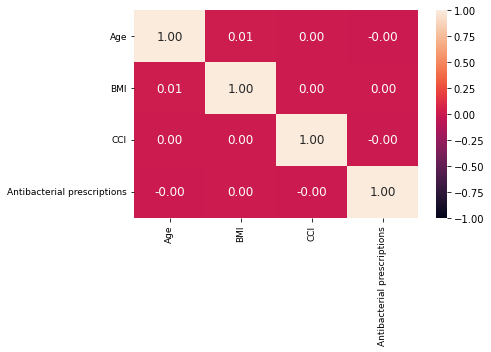

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_sinusitis[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_sinusitis/corr_sinusitis.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [33]:
data_sinusitis = data_sinusitis[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'sinusitis_ab_date', 'ab_type_cat', 'incdt_sinusitis_date', 'date', 'period',
                                   'event_sinusitis_admitted', 'duration_sinusitis_admitted'
                                    ]]

In [34]:
#switch variable sinusitis_ab_date into a binary variable
data_sinusitis[['ab_binary']] = data_sinusitis[['sinusitis_ab_date']].where(data_sinusitis[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_sinusitis_incdt = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 0]
data_sinusitis_prevl = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 1]

#no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt = data_sinusitis_incdt[data_sinusitis_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_sinusitis_abs_incdt = data_sinusitis_incdt[data_sinusitis_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_sinusitis_no_abs_prevl = data_sinusitis_prevl[data_sinusitis_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_sinusitis_abs_prevl = data_sinusitis_prevl[data_sinusitis_prevl['ab_binary'] == 1]

In [35]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_sinusitis_incdt_prepandemic = data_sinusitis_incdt[data_sinusitis_incdt['period'] == 'prepandemic']
data_sinusitis_incdt_during_pandemic = data_sinusitis_incdt[(data_sinusitis_incdt['period'] == 'during_pandemic')]
data_sinusitis_incdt_post_2nd_lockdown = data_sinusitis_incdt[data_sinusitis_incdt['period'] == 'post_2nd_lockdown']
data_sinusitis_prevl_prepandemic = data_sinusitis_prevl[data_sinusitis_prevl['period'] == 'prepandemic']
data_sinusitis_prevl_during_pandemic = data_sinusitis_prevl[(data_sinusitis_prevl['period'] == 'during_pandemic')]
data_sinusitis_prevl_post_2nd_lockdown = data_sinusitis_prevl[data_sinusitis_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt_prepandemic = data_sinusitis_incdt_prepandemic[data_sinusitis_incdt_prepandemic['ab_binary'] == 0]
data_sinusitis_no_abs_incdt_during_pandemic = data_sinusitis_incdt_during_pandemic[data_sinusitis_incdt_during_pandemic['ab_binary'] == 0]
data_sinusitis_no_abs_incdt_post_2nd_lockdown = data_sinusitis_incdt_post_2nd_lockdown[data_sinusitis_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_sinusitis_no_abs_prevl_prepandemic = data_sinusitis_prevl_prepandemic[data_sinusitis_prevl_prepandemic['ab_binary'] == 0]
data_sinusitis_no_abs_prevl_during_pandemic = data_sinusitis_prevl_during_pandemic[data_sinusitis_prevl_during_pandemic['ab_binary'] == 0]
data_sinusitis_no_abs_prevl_post_2nd_lockdown = data_sinusitis_prevl_post_2nd_lockdown[data_sinusitis_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [36]:
#store data for plotting hosp admission counts and percentages
%store data_sinusitis
# save data
data_sinusitis.to_csv('../output/hospitalisation_prediction_sinusitis/data_sinusitis.csv')

Stored 'data_sinusitis' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [37]:
#make summary tables
make_summary_table('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)
make_summary_table('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)
make_summary_table('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)
make_summary_table('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 110175 total observations, 109440 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 110175
number of events observed = 735
   partial log-likelihood = -8508.34
         time fit was run = 2023-07-30 22:34:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.11            -0.23             0.20                 0.79                 1.22
CCI_cat[T.medium]                0.09       1.10       0.12            -0.14             0.33                 0.87                 1.39
CCI_cat[T.high]                 -0.10       0.90       0.15            -0.40             0.19                 0.67                 1.21
CCI_cat[T.very_high]             0.03       1.03       0.13            -0.22             0.28                 0.80                 1.32
age_cat[T.25_34]                 0.19       1.21       0.14            -0.09             0.46                 0.92                 1.59
age_cat[T.35_44]                -0.04       0.96       0.15            -0.33             0.25                 0.72                 1.28
age_cat[T.45_54]                 0.18       1.20       0.14            -0.09             0.45                 0.91                 1.57
age_cat[T.55_64]                 0.14       1.15       0.14            -0.13             0.42                 0.87                 1.52
age_cat[T.65_74]                 0.12       1.12       0.14            -0.16             0.40                 0.85                 1.48
age_cat[T.75_more]               0.18       1.20       0.14            -0.10             0.45                 0.91                 1.58
antibacterial_brit               0.04       1.04       0.03            -0.01             0.09                 0.99                 1.10
bmi_cat[T.obese]                -0.07       0.93       0.13            -0.33             0.19                 0.72                 1.20
bmi_cat[T.overweight]           -0.26       0.77       0.17            -0.59             0.07                 0.55                 1.07
bmi_cat[T.underweight]          -0.32       0.73       0.26            -0.83             0.19                 0.44                 1.21
bmi_cat[T.unknown]              -0.13       0.88       0.14            -0.41             0.15                 0.66                 1.16
ethnicity[T.other]               0.05       1.05       0.19            -0.31             0.42                 0.73                 1.52
ethnicity[T.unknown]             0.13       1.14       0.15            -0.16             0.43                 0.85                 1.54
ethnicity[T.white]              -0.09       0.91       0.14            -0.37             0.19                 0.69                 1.21
flu_vaccine[T.yes]               0.08       1.09       0.12            -0.15             0.32                 0.86                 1.37
imd[T.medium]                   -0.10       0.90       0.12            -0.34             0.13                 0.71                 1.13
imd[T.unaffluent]                0.02       1.02       0.11            -0.21             0.24                 0.81                 1.27
imd[T.unknown]                  -0.13       0.88       0.19            -0.50             0.24                 0.61                 1.27
imd[T.very_affluent]            -0.03       0.97       0.12            -0.26             0.19                 0.77                 1.21
imd[T.very_unaffluent]          -0.31       0.73       0.12            -0.56            -0.07                 0.57                 0.93
region[T.east_midlands]          0.04       1.04       

13061


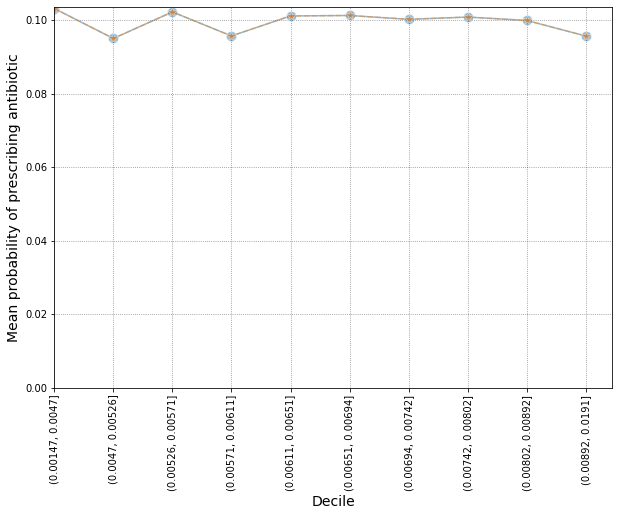


AUROC of LR for deciles with development and validation data: 0.51001 and 0.50286
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.0047, 0.00526]  -0.117409   -0.123002   -0.111816  0.889221   
bins_(0.00526, 0.00571] -0.029863   -0.035437   -0.024289  0.970579   
bins_(0.00571, 0.00611] -0.115011   -0.120586   -0.109436  0.891356   
bins_(0.00611, 0.00651] -0.046397   -0.051966   -0.040828  0.954663   
bins_(0.00651, 0.00694] -0.062470   -0.068041   -0.056899  0.939441   
bins_(0.00694, 0.00742] -0.066915   -0.072505   -0.061325  0.935274   
bins_(0.00742, 0.00802] -0.057032   -0.062624   -0.051440  0.944564   
bins_(0.00802, 0.00892] -0.060467   -0.066037   -0.054898  0.941324   
bins_(0.00892, 0.0191]  -0.108553   -0.114137   -0.102969  0.897132   

                         ors_lower  ors_upper  
bins_(0.0047, 0.00526]    0.884262   0.894209  
bins_(0.00526, 0.00571]   0.965184   0.976004  
bins_(0.00571, 0.00611]   0.886401   0.896339  
bins_

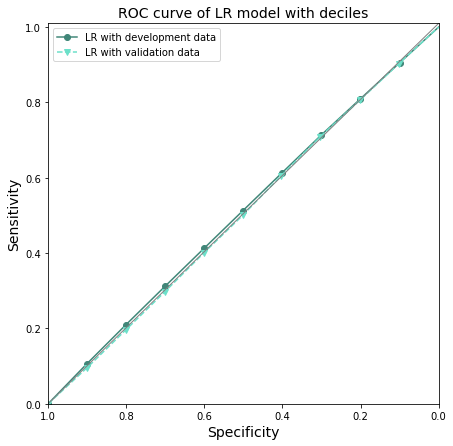

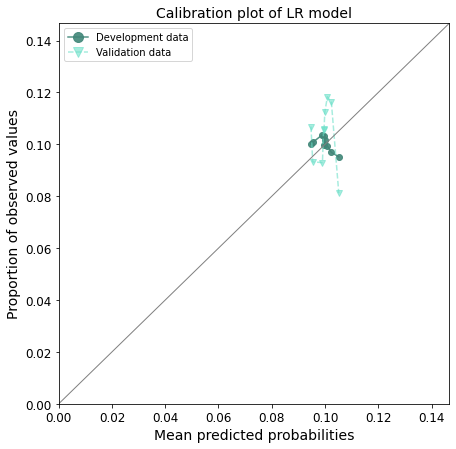


AUROC of LR for risk factors with development and validation data: 0.51473 and 0.49711
LR ORs:
                                  coef  coef_lower  coef_upper       ors  \
age_cat_25_34                0.051754    0.045282    0.058225  1.053116   
age_cat_35_44               -0.020311   -0.026737   -0.013885  0.979894   
age_cat_45_54                0.024288    0.017853    0.030722  1.024585   
age_cat_55_64               -0.018820   -0.025277   -0.012363  0.981356   
age_cat_65_74                0.001202   -0.005275    0.007679  1.001203   
age_cat_75_more              0.050401    0.043923    0.056879  1.051692   
sex_male                     0.001873   -0.001645    0.005392  1.001875   
CCI_cat_high                 0.013212    0.006431    0.019993  1.013300   
CCI_cat_low                  0.011662    0.006589    0.016735  1.011730   
CCI_cat_medium               0.015507    0.009843    0.021172  1.015628   
CCI_cat_very_high            0.028850    0.022880    0.034820  1.029270   
flu

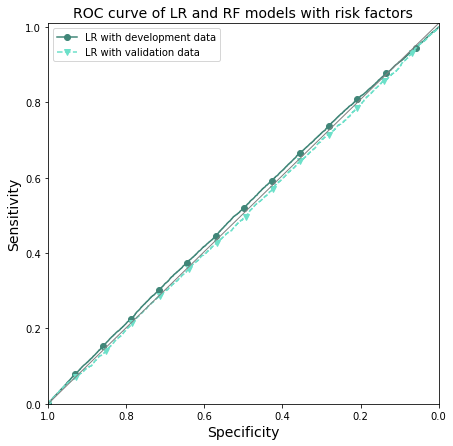

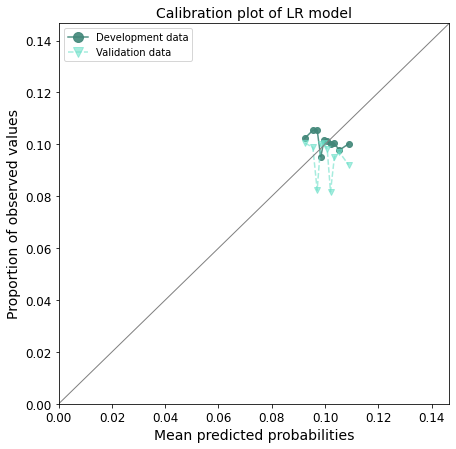

In [38]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt, prob_pred_sinusitis_no_abs_incdt_bin = cox_build('sinusitis', 'incdt', data_sinusitis_incdt, data_sinusitis_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models with deciles as predictors
    prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_deciles('sinusitis', 'incdt_deciles', prob_pred_sinusitis_no_abs_incdt)
    #calibration plots of rf and lr with deciles
    calibration_rf_lr('sinusitis', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('sinusitis', 'incdt', prob_pred_enc_lr_rf_incdt)

try:
    #build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_riskfactors('sinusitis', 'incdt_riskfactors', prob_pred_sinusitis_no_abs_incdt)
    #calibration plots of rf and lr with risk factors
    calibration_rf_lr('sinusitis', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
except:
    print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12179 total observations, 12117 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 12179
number of events observed = 62
   partial log-likelihood = -560.96
         time fit was run = 2023-07-30 22:35:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.19       0.83       0.35            -0.87             0.49                 0.42                 1.64
CCI_cat[T.medium]               -0.25       0.78       0.39            -1.03             0.52                 0.36                 1.68
CCI_cat[T.high]                 -0.18       0.83       0.47            -1.11             0.74                 0.33                 2.09
CCI_cat[T.very_high]            -0.76       0.47       0.49            -1.73             0.21                 0.18                 1.23
age_cat[T.25_34]                 0.99       2.68       0.48             0.04             1.93                 1.04                 6.92
age_cat[T.35_44]                -0.05       0.95       0.58            -1.18             1.08                 0.31                 2.95
age_cat[T.45_54]                 0.19       1.21       0.56            -0.91             1.28                 0.40                 3.59
age_cat[T.55_64]                 0.68       1.97       0.51            -0.32             1.67                 0.73                 5.32
age_cat[T.65_74]                 0.50       1.65       0.53            -0.54             1.53                 0.59                 4.64
age_cat[T.75_more]               0.31       1.37       0.54            -0.75             1.37                 0.47                 3.95
antibacterial_brit              -0.07       0.93       0.09            -0.25             0.11                 0.78                 1.12
bmi_cat[T.obese]                -0.13       0.87       0.49            -1.09             0.82                 0.34                 2.27
bmi_cat[T.overweight]            0.23       1.25       0.57            -0.89             1.35                 0.41                 3.85
bmi_cat[T.underweight]           1.01       2.74       0.63            -0.24             2.25                 0.79                 9.49
bmi_cat[T.unknown]              -0.03       0.97       0.52            -1.04             0.99                 0.35                 2.69
ethnicity[T.other]              -0.25       0.78       0.59            -1.40             0.90                 0.25                 2.46
ethnicity[T.unknown]            -0.66       0.52       0.48            -1.60             0.27                 0.20                 1.31
ethnicity[T.white]              -0.37       0.69       0.41            -1.18             0.44                 0.31                 1.56
flu_vaccine[T.yes]               0.13       1.14       0.40            -0.65             0.92                 0.52                 2.52
imd[T.medium]                   -0.39       0.68       0.37            -1.12             0.34                 0.33                 1.41
imd[T.unaffluent]               -0.39       0.68       0.37            -1.12             0.34                 0.33                 1.41
imd[T.unknown]                  -0.35       0.70       0.62            -1.58             0.87                 0.21                 2.39
imd[T.very_affluent]            -0.51       0.60       0.38            -1.26             0.24                 0.28                 1.28
imd[T.very_unaffluent]          -1.16       0.31       0.47            -2.08            -0.23                 0.12                 0.79
region[T.east_midlands]         -1.06       0.35       0.68 

13099


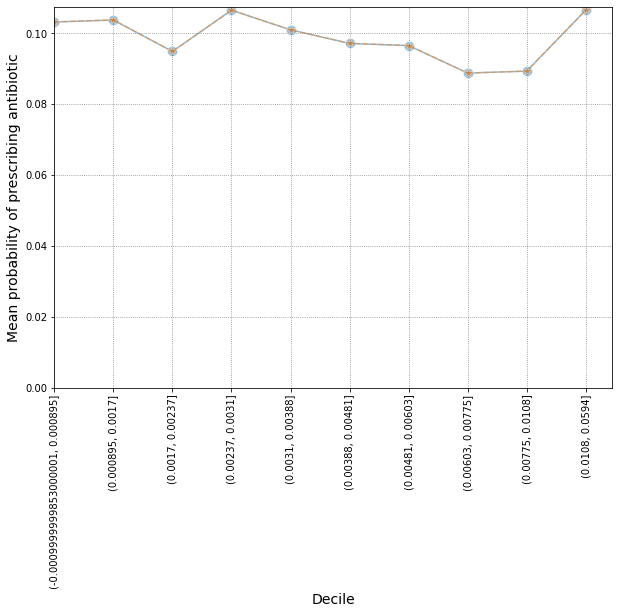


AUROC of LR for deciles with development and validation data: 0.52716 and 0.48305
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.000895, 0.0017] -0.014592   -0.031459    0.002275  0.985514   
bins_(0.0017, 0.00237]   0.020564    0.003551    0.037577  1.020777   
bins_(0.00237, 0.0031]   0.131153    0.114229    0.148076  1.140142   
bins_(0.0031, 0.00388]  -0.023524   -0.040575   -0.006472  0.976751   
bins_(0.00388, 0.00481] -0.073944   -0.090736   -0.057151  0.928724   
bins_(0.00481, 0.00603] -0.058507   -0.075418   -0.041596  0.943171   
bins_(0.00603, 0.00775] -0.215166   -0.231971   -0.198362  0.806407   
bins_(0.00775, 0.0108]  -0.152659   -0.169312   -0.136007  0.858422   
bins_(0.0108, 0.0594]    0.080930    0.064107    0.097753  1.084295   

                         ors_lower  ors_upper  
bins_(0.000895, 0.0017]   0.969030   1.002278  
bins_(0.0017, 0.00237]    1.003557   1.038292  
bins_(0.00237, 0.0031]    1.121009   1.159601  
bins_

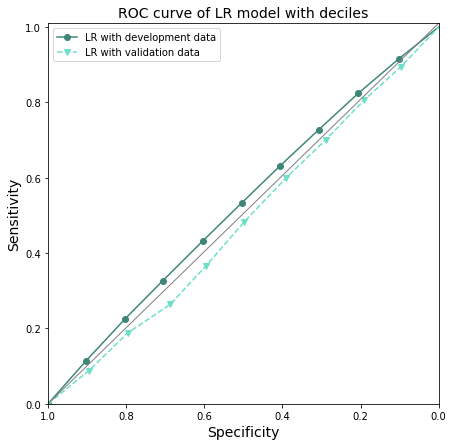

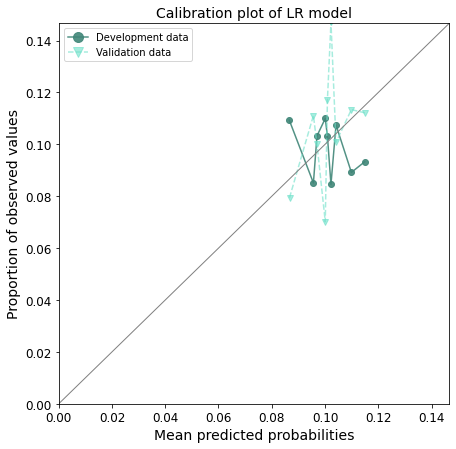


AUROC of LR for risk factors with development and validation data: 0.54614 and 0.52094
LR ORs:
                                  coef  coef_lower  coef_upper       ors  \
age_cat_25_34                0.078908    0.059634    0.098182  1.082104   
age_cat_35_44               -0.005145   -0.024286    0.013995  0.994868   
age_cat_45_54               -0.077960   -0.097299   -0.058620  0.925002   
age_cat_55_64               -0.070151   -0.089612   -0.050691  0.932253   
age_cat_65_74                0.035797    0.016295    0.055300  1.036446   
age_cat_75_more              0.015140   -0.004177    0.034457  1.015255   
sex_male                     0.068245    0.057651    0.078839  1.070627   
CCI_cat_high                -0.170490   -0.190944   -0.150035  0.843252   
CCI_cat_low                 -0.028057   -0.043356   -0.012758  0.972333   
CCI_cat_medium              -0.067052   -0.084095   -0.050008  0.935147   
CCI_cat_very_high            0.014244   -0.003906    0.032395  1.014346   
flu

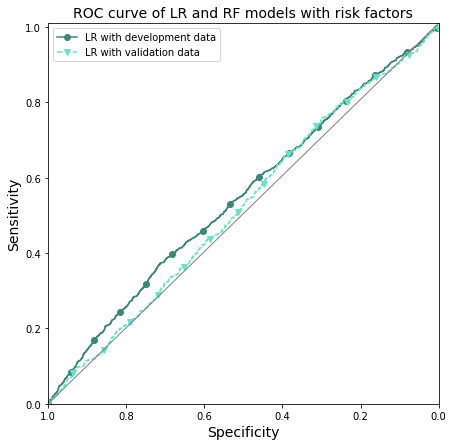

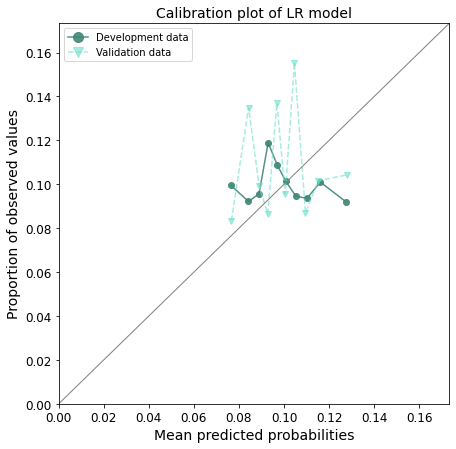

In [40]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl, prob_pred_sinusitis_no_abs_prevl_bin = cox_build('sinusitis', 'prevl', data_sinusitis_prevl, data_sinusitis_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models with deciles as predictors
    prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_deciles('sinusitis', 'prevl_deciles', prob_pred_sinusitis_no_abs_prevl)
    #calibration plots of rf and lr with deciles
    calibration_rf_lr('sinusitis', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('sinusitis', 'prevl', prob_pred_enc_lr_rf_prevl)

try:
    #build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_riskfactors('sinusitis', 'prevl_riskfactors', prob_pred_sinusitis_no_abs_prevl)
    #calibration plots of rf and lr with risk factors
    calibration_rf_lr('sinusitis', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
except:
    print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28560 total observations, 28396 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 28560
number of events observed = 164
   partial log-likelihood = -1660.82
         time fit was run = 2023-07-30 22:35:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.41       0.66       0.22            -0.84             0.01                 0.43                 1.01
CCI_cat[T.medium]               -0.33       0.72       0.24            -0.81             0.14                 0.44                 1.15
CCI_cat[T.high]                 -0.28       0.76       0.29            -0.85             0.29                 0.43                 1.33
CCI_cat[T.very_high]            -0.29       0.75       0.25            -0.79             0.21                 0.45                 1.23
age_cat[T.25_34]                 0.30       1.35       0.30            -0.28             0.88                 0.76                 2.40
age_cat[T.35_44]                 0.13       1.14       0.31            -0.47             0.73                 0.62                 2.07
age_cat[T.45_54]                 0.30       1.35       0.29            -0.27             0.88                 0.76                 2.40
age_cat[T.55_64]                 0.07       1.07       0.31            -0.54             0.67                 0.58                 1.96
age_cat[T.65_74]                 0.08       1.08       0.31            -0.53             0.69                 0.59                 1.99
age_cat[T.75_more]               0.07       1.08       0.31            -0.53             0.68                 0.59                 1.97
antibacterial_brit               0.02       1.02       0.05            -0.08             0.13                 0.92                 1.14
bmi_cat[T.obese]                -0.30       0.74       0.26            -0.81             0.21                 0.44                 1.23
bmi_cat[T.overweight]           -0.90       0.40       0.39            -1.68            -0.13                 0.19                 0.88
bmi_cat[T.underweight]          -0.56       0.57       0.55            -1.64             0.53                 0.19                 1.70
bmi_cat[T.unknown]              -0.17       0.85       0.28            -0.71             0.38                 0.49                 1.46
ethnicity[T.other]               0.25       1.28       0.38            -0.50             1.00                 0.61                 2.71
ethnicity[T.unknown]             0.10       1.10       0.33            -0.54             0.74                 0.58                 2.09
ethnicity[T.white]              -0.06       0.94       0.31            -0.67             0.54                 0.51                 1.71
flu_vaccine[T.yes]              -0.02       0.98       0.26            -0.54             0.50                 0.59                 1.64
imd[T.medium]                   -0.14       0.87       0.26            -0.65             0.37                 0.52                 1.45
imd[T.unaffluent]               -0.04       0.96       0.25            -0.53             0.45                 0.59                 1.58
imd[T.unknown]                  -0.18       0.84       0.42            -0.99             0.64                 0.37                 1.90
imd[T.very_affluent]             0.24       1.27       0.24            -0.22             0.71                 0.80                 2.03
imd[T.very_unaffluent]          -0.25       0.78       0.27            -0.77             0.28                 0.46                 1.32
region[T.east_midlands]         -0.61       0.54       0.3

13070


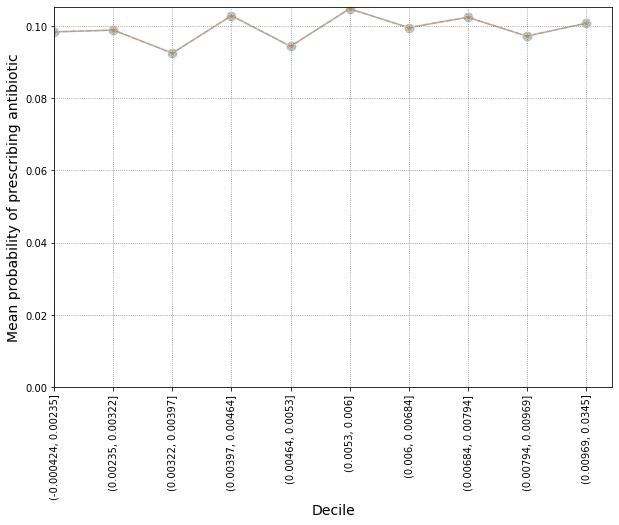


AUROC of LR for deciles with development and validation data: 0.51482 and 0.49823
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00235, 0.00322] -0.009936   -0.020856    0.000984  0.990113   
bins_(0.00322, 0.00397] -0.070207   -0.081121   -0.059294  0.932200   
bins_(0.00397, 0.00464]  0.074965    0.064103    0.085827  1.077847   
bins_(0.00464, 0.0053]  -0.103645   -0.114583   -0.092708  0.901545   
bins_(0.0053, 0.006]     0.037603    0.026709    0.048498  1.038319   
bins_(0.006, 0.00684]    0.029691    0.018767    0.040615  1.030136   
bins_(0.00684, 0.00794]  0.061714    0.050835    0.072594  1.063659   
bins_(0.00794, 0.00969] -0.024287   -0.035154   -0.013420  0.976006   
bins_(0.00969, 0.0345]   0.016027    0.005102    0.026952  1.016156   

                         ors_lower  ors_upper  
bins_(0.00235, 0.00322]   0.979360   1.000985  
bins_(0.00322, 0.00397]   0.922082   0.942430  
bins_(0.00397, 0.00464]   1.066203   1.089618  
bins_

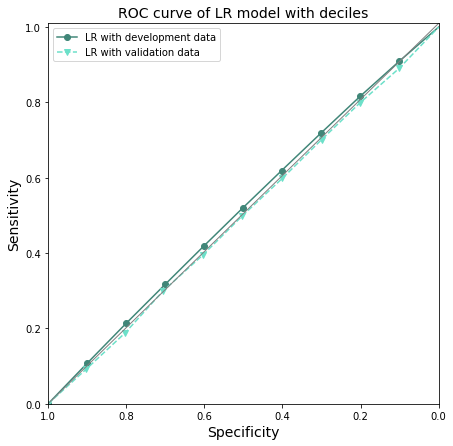

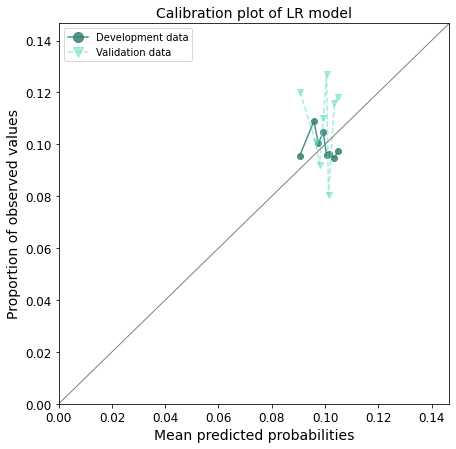

In [41]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt_prepandemic, prob_pred_sinusitis_no_abs_incdt_prepandemic_bin = cox_build('sinusitis', 'incdt_prepandemic', data_sinusitis_incdt_prepandemic, data_sinusitis_no_abs_incdt_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('sinusitis', 'incdt_prepandemic_deciles', prob_pred_sinusitis_no_abs_incdt_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('sinusitis', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic)#, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 26143 total observations, 25989 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 26143
number of events observed = 154
   partial log-likelihood = -1548.39
         time fit was run = 2023-07-30 22:35:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.71       0.23            -0.79             0.10                 0.45                 1.10
CCI_cat[T.medium]               -0.28       0.75       0.25            -0.78             0.21                 0.46                 1.23
CCI_cat[T.high]                 -0.56       0.57       0.34            -1.22             0.10                 0.29                 1.11
CCI_cat[T.very_high]            -0.02       0.98       0.25            -0.51             0.46                 0.60                 1.59
age_cat[T.25_34]                 0.00       1.00       0.30            -0.59             0.59                 0.55                 1.81
age_cat[T.35_44]                -0.06       0.94       0.31            -0.66             0.54                 0.52                 1.72
age_cat[T.45_54]                 0.13       1.14       0.29            -0.44             0.71                 0.64                 2.02
age_cat[T.55_64]                -0.35       0.71       0.33            -0.99             0.30                 0.37                 1.35
age_cat[T.65_74]                 0.16       1.17       0.29            -0.41             0.73                 0.67                 2.07
age_cat[T.75_more]               0.04       1.04       0.30            -0.55             0.63                 0.58                 1.89
antibacterial_brit               0.06       1.06       0.06            -0.05             0.17                 0.95                 1.19
bmi_cat[T.obese]                 0.24       1.28       0.34            -0.41             0.90                 0.66                 2.46
bmi_cat[T.overweight]           -0.12       0.88       0.43            -0.96             0.72                 0.38                 2.04
bmi_cat[T.underweight]           0.63       1.88       0.49            -0.34             1.60                 0.72                 4.95
bmi_cat[T.unknown]               0.39       1.47       0.35            -0.30             1.07                 0.74                 2.92
ethnicity[T.other]               0.41       1.50       0.46            -0.49             1.30                 0.61                 3.67
ethnicity[T.unknown]             0.43       1.54       0.39            -0.33             1.19                 0.72                 3.28
ethnicity[T.white]               0.36       1.44       0.37            -0.36             1.09                 0.70                 2.96
flu_vaccine[T.yes]               0.26       1.29       0.25            -0.23             0.74                 0.80                 2.09
imd[T.medium]                   -0.11       0.90       0.27            -0.63             0.41                 0.53                 1.51
imd[T.unaffluent]                0.15       1.16       0.25            -0.34             0.63                 0.71                 1.89
imd[T.unknown]                   0.37       1.45       0.34            -0.30             1.04                 0.74                 2.84
imd[T.very_affluent]            -0.15       0.86       0.27            -0.67             0.38                 0.51                 1.46
imd[T.very_unaffluent]          -0.23       0.80       0.27            -0.76             0.31                 0.47                 1.37
region[T.east_midlands]         -0.15       0.86       0.3

13063


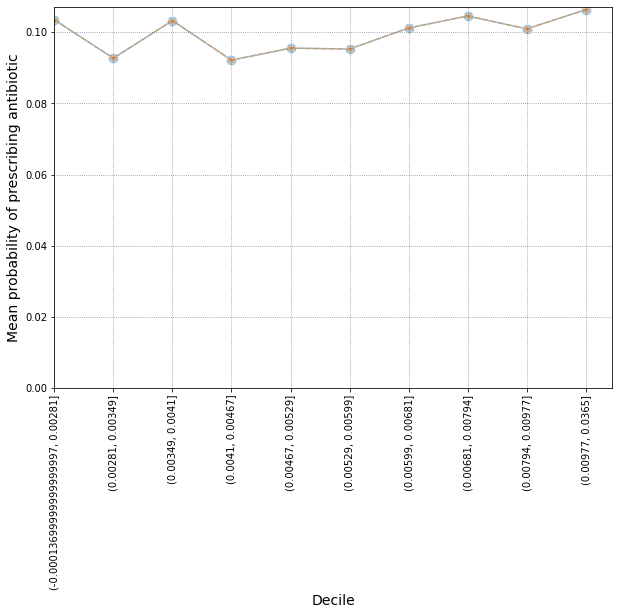


AUROC of LR for deciles with development and validation data: 0.51618 and 0.50608
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00281, 0.00349] -0.062281   -0.073906   -0.050656  0.939619   
bins_(0.00349, 0.0041]   0.058533    0.047054    0.070012  1.060280   
bins_(0.0041, 0.00467]  -0.156589   -0.168147   -0.145030  0.855056   
bins_(0.00467, 0.00529] -0.071514   -0.083028   -0.059999  0.930984   
bins_(0.00529, 0.00599] -0.066578   -0.078118   -0.055038  0.935590   
bins_(0.00599, 0.00681] -0.006936   -0.018488    0.004616  0.993088   
bins_(0.00681, 0.00794] -0.018464   -0.030054   -0.006873  0.981706   
bins_(0.00794, 0.00977] -0.034914   -0.046399   -0.023429  0.965688   
bins_(0.00977, 0.0365]   0.040241    0.028728    0.051753  1.041061   

                         ors_lower  ors_upper  
bins_(0.00281, 0.00349]   0.928759   0.950606  
bins_(0.00349, 0.0041]    1.048178   1.072521  
bins_(0.0041, 0.00467]    0.845230   0.864996  
bins_

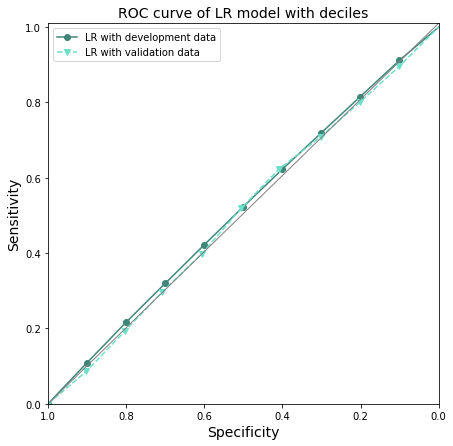

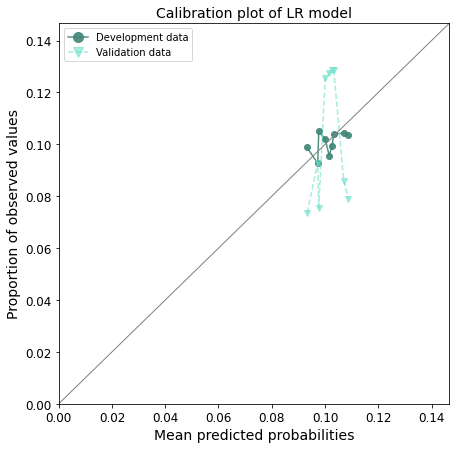

In [42]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt_during_pandemic, prob_pred_sinusitis_no_abs_incdt_during_pandemic_bin = cox_build('sinusitis', 'incdt_during_pandemic', data_sinusitis_incdt_during_pandemic, data_sinusitis_no_abs_incdt_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('sinusitis', 'incdt_during_pandemic_deciles', prob_pred_sinusitis_no_abs_incdt_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('sinusitis', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic)#, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 46439 total observations, 46098 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 46439
number of events observed = 341
   partial log-likelihood = -3633.97
         time fit was run = 2023-07-30 22:35:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.36       1.43       0.18             0.00             0.71                 1.00                 2.03
CCI_cat[T.medium]                0.60       1.82       0.19             0.23             0.96                 1.26                 2.62
CCI_cat[T.high]                  0.12       1.13       0.24            -0.35             0.59                 0.71                 1.81
CCI_cat[T.very_high]             0.17       1.19       0.21            -0.24             0.59                 0.79                 1.80
age_cat[T.25_34]                 0.09       1.09       0.21            -0.31             0.49                 0.73                 1.64
age_cat[T.35_44]                -0.16       0.86       0.22            -0.58             0.27                 0.56                 1.31
age_cat[T.45_54]                -0.08       0.92       0.21            -0.50             0.34                 0.61                 1.40
age_cat[T.55_64]                 0.10       1.10       0.21            -0.31             0.50                 0.74                 1.65
age_cat[T.65_74]                 0.17       1.19       0.20            -0.22             0.56                 0.80                 1.76
age_cat[T.75_more]               0.25       1.28       0.20            -0.14             0.64                 0.87                 1.89
antibacterial_brit               0.07       1.07       0.04            -0.00             0.14                 1.00                 1.15
bmi_cat[T.obese]                -0.15       0.86       0.19            -0.53             0.22                 0.59                 1.25
bmi_cat[T.overweight]            0.07       1.07       0.23            -0.38             0.52                 0.68                 1.67
bmi_cat[T.underweight]          -0.74       0.48       0.45            -1.61             0.13                 0.20                 1.14
bmi_cat[T.unknown]              -0.16       0.86       0.21            -0.56             0.25                 0.57                 1.29
ethnicity[T.other]              -0.47       0.63       0.30            -1.04             0.11                 0.35                 1.12
ethnicity[T.unknown]             0.08       1.09       0.21            -0.33             0.49                 0.72                 1.64
ethnicity[T.white]              -0.22       0.80       0.20            -0.61             0.17                 0.54                 1.19
flu_vaccine[T.yes]               0.27       1.31       0.16            -0.05             0.59                 0.95                 1.80
imd[T.medium]                   -0.20       0.81       0.17            -0.54             0.13                 0.58                 1.14
imd[T.unaffluent]               -0.15       0.86       0.17            -0.48             0.18                 0.62                 1.20
imd[T.unknown]                  -0.10       0.90       0.26            -0.62             0.41                 0.54                 1.51
imd[T.very_affluent]            -0.08       0.93       0.17            -0.40             0.25                 0.67                 1.28
imd[T.very_unaffluent]          -0.33       0.72       0.18            -0.68             0.02                 0.51                 1.03
region[T.east_midlands]          0.18       1.20       0.2

13063


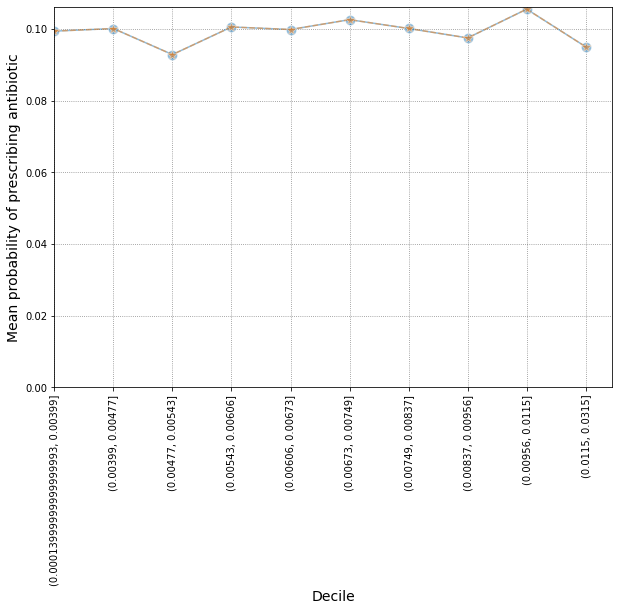


AUROC of LR for deciles with development and validation data: 0.51316 and 0.49965
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00399, 0.00477] -0.000731   -0.009322    0.007860  0.999269   
bins_(0.00477, 0.00543] -0.093593   -0.102220   -0.084967  0.910653   
bins_(0.00543, 0.00606]  0.002348   -0.006288    0.010984  1.002351   
bins_(0.00606, 0.00673] -0.004763   -0.013388    0.003862  0.995248   
bins_(0.00673, 0.00749]  0.035476    0.026810    0.044142  1.036113   
bins_(0.00749, 0.00837] -0.049040   -0.057620   -0.040460  0.952143   
bins_(0.00837, 0.00956] -0.058439   -0.067008   -0.049869  0.943236   
bins_(0.00956, 0.0115]   0.078568    0.069974    0.087162  1.081737   
bins_(0.0115, 0.0315]   -0.050347   -0.058992   -0.041703  0.950899   

                         ors_lower  ors_upper  
bins_(0.00399, 0.00477]   0.990721   1.007891  
bins_(0.00477, 0.00543]   0.902831   0.918543  
bins_(0.00543, 0.00606]   0.993732   1.011045  
bins_

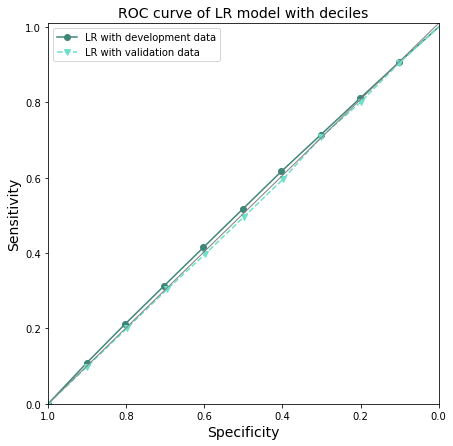

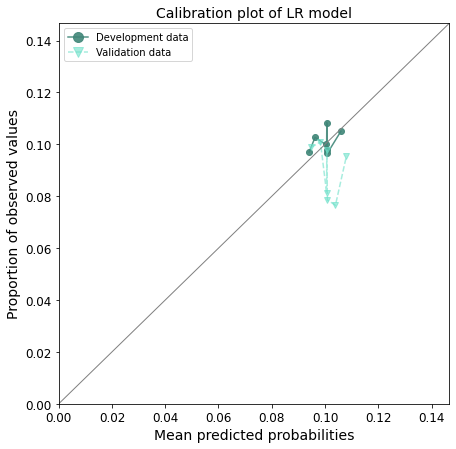

In [43]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt_post_2nd_lockdown, prob_pred_sinusitis_no_abs_incdt_post_2nd_lockdown_bin = cox_build('sinusitis', 'incdt_post_2nd_lockdown', data_sinusitis_incdt_post_2nd_lockdown, data_sinusitis_no_abs_incdt_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('sinusitis', 'incdt_post_2nd_lockdown_deciles', prob_pred_sinusitis_no_abs_incdt_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('sinusitis', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown)#, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3174 total observations, 3154 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 3174
number of events observed = 20
   partial log-likelihood = -141.81
         time fit was run = 2023-07-30 22:35:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.51       1.67       0.67            -0.79             1.82                 0.45                 6.16
CCI_cat[T.medium]               -0.41       0.66       0.82            -2.03             1.20                 0.13                 3.33
CCI_cat[T.high]                  0.42       1.51       0.83            -1.21             2.04                 0.30                 7.71
CCI_cat[T.very_high]            -1.01       0.36       1.16            -3.29             1.26                 0.04                 3.54
age_cat[T.25_34]                 1.28       3.61       0.83            -0.35             2.91                 0.71                18.38
age_cat[T.35_44]                 0.03       1.03       1.01            -1.96             2.01                 0.14                 7.48
age_cat[T.45_54]                -0.76       0.47       1.23            -3.18             1.66                 0.04                 5.27
age_cat[T.55_64]                 0.37       1.45       0.93            -1.45             2.20                 0.23                 9.00
age_cat[T.65_74]                 0.70       2.01       0.88            -1.03             2.42                 0.36                11.23
age_cat[T.75_more]               0.11       1.12       1.01            -1.88             2.09                 0.15                 8.13
antibacterial_brit              -0.13       0.88       0.17            -0.47             0.20                 0.63                 1.23
bmi_cat[T.obese]                -0.31       0.73       0.78            -1.84             1.23                 0.16                 3.41
bmi_cat[T.overweight]          -18.38       0.00    5358.06        -10519.99         10483.22                 0.00                  inf
bmi_cat[T.underweight]           1.11       3.02       1.04            -0.93             3.14                 0.40                23.06
bmi_cat[T.unknown]              -0.34       0.71       0.85            -2.01             1.34                 0.13                 3.81
ethnicity[T.other]              -0.55       0.58       1.24            -2.98             1.88                 0.05                 6.55
ethnicity[T.unknown]            -0.79       0.45       0.93            -2.61             1.03                 0.07                 2.80
ethnicity[T.white]              -0.14       0.87       0.77            -1.65             1.38                 0.19                 3.97
flu_vaccine[T.yes]               0.83       2.30       0.58            -0.29             1.96                 0.74                 7.12
imd[T.medium]                   -1.23       0.29       1.13            -3.43             0.98                 0.03                 2.66
imd[T.unaffluent]                0.12       1.12       0.72            -1.30             1.53                 0.27                 4.64
imd[T.unknown]                 -17.94       0.00    7833.70        -15371.71         15335.83                 0.00                  inf
imd[T.very_affluent]             0.52       1.68       0.66            -0.77             1.81                 0.46                 6.14
imd[T.very_unaffluent]           0.33       1.39       0.69            -1.03             1.68                 0.36                 5.38
region[T.east_midlands]         -0.66       0.51       1.23    

13135


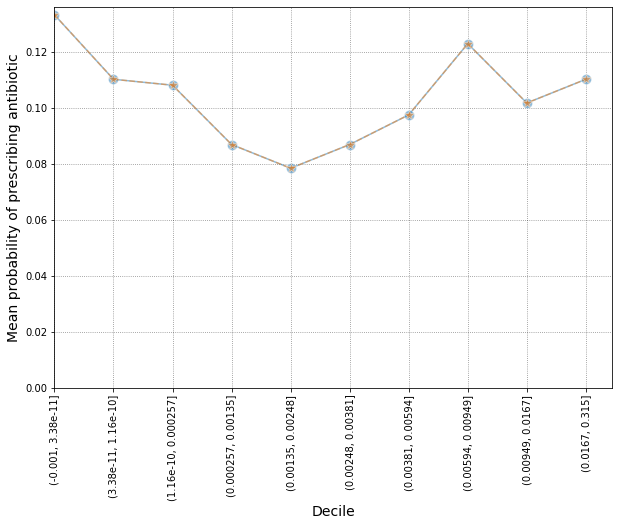


AUROC of LR for deciles with development and validation data: 0.55787 and 0.49858
LR ORs:
                                coef  coef_lower  coef_upper       ors  \
bins_(0.000257, 0.00135]  -0.517249   -0.551669   -0.482829  0.596159   
bins_(0.00135, 0.00248]   -0.635777   -0.668862   -0.602693  0.529524   
bins_(0.00248, 0.00381]   -0.592054   -0.625834   -0.558274  0.553190   
bins_(0.00381, 0.00594]   -0.334025   -0.367382   -0.300667  0.716036   
bins_(0.00594, 0.00949]   -0.241541   -0.275465   -0.207616  0.785417   
bins_(0.00949, 0.0167]    -0.305977   -0.339335   -0.272620  0.736403   
bins_(0.0167, 0.315]      -0.356682   -0.390132   -0.323232  0.699995   
bins_(1.16e-10, 0.000257] -0.429577   -0.463797   -0.395358  0.650784   
bins_(3.38e-11, 1.16e-10] -0.201824   -0.235944   -0.167704  0.817239   

                           ors_lower  ors_upper  
bins_(0.000257, 0.00135]    0.575988   0.617035  
bins_(0.00135, 0.00248]     0.512291   0.547336  
bins_(0.00248, 0.00381]    

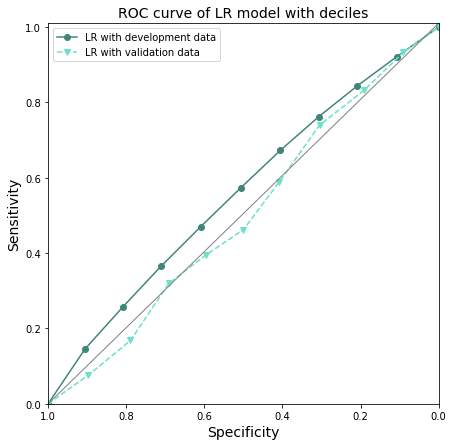

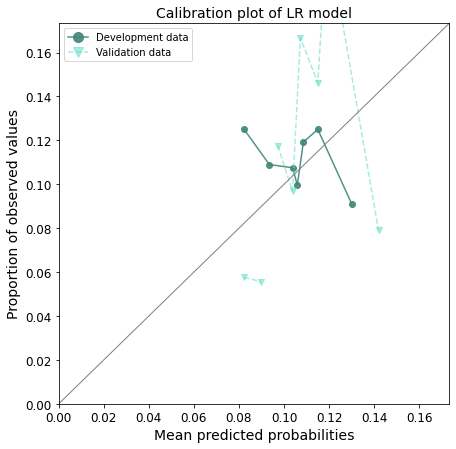

In [44]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl_prepandemic, prob_pred_sinusitis_no_abs_prevl_prepandemic_bin = cox_build('sinusitis', 'prevl_prepandemic', data_sinusitis_prevl_prepandemic, data_sinusitis_no_abs_prevl_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('sinusitis', 'prevl_prepandemic_deciles', prob_pred_sinusitis_no_abs_prevl_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('sinusitis', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic)#, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 2943 total observations, 2930 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 2943
number of events observed = 13
   partial log-likelihood = -81.93
         time fit was run = 2023-07-30 22:35:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.71       0.89            -2.09             1.39                 0.12                 4.03
CCI_cat[T.medium]                0.54       1.72       0.86            -1.15             2.23                 0.32                 9.34
CCI_cat[T.high]                  0.09       1.09       1.04            -1.95             2.12                 0.14                 8.33
CCI_cat[T.very_high]           -18.15       0.00    5620.44        -11034.00         10997.70                 0.00                  inf
age_cat[T.25_34]                 1.79       5.98       1.11            -0.40             3.97                 0.67                53.03
age_cat[T.35_44]               -17.58       0.00    6719.50        -13187.55         13152.40                 0.00                  inf
age_cat[T.45_54]                 0.70       2.01       1.25            -1.74             3.14                 0.17                23.04
age_cat[T.55_64]                 0.14       1.15       1.43            -2.66             2.94                 0.07                18.91
age_cat[T.65_74]                 1.42       4.12       1.17            -0.88             3.72                 0.41                41.11
age_cat[T.75_more]               0.26       1.30       1.43            -2.54             3.06                 0.08                21.40
antibacterial_brit               0.02       1.02       0.20            -0.37             0.41                 0.69                 1.50
bmi_cat[T.obese]                18.32   9.08e+07    9044.63        -17708.83         17745.48                 0.00                  inf
bmi_cat[T.overweight]           17.83   5.56e+07    9044.63        -17709.32         17744.99                 0.00                  inf
bmi_cat[T.underweight]           0.26       1.29   16123.14        -31600.51         31601.03                 0.00                  inf
bmi_cat[T.unknown]              18.30   8.82e+07    9044.63        -17708.86         17745.45                 0.00                  inf
ethnicity[T.other]              -0.74       0.48       1.26            -3.19             1.72                 0.04                 5.61
ethnicity[T.unknown]            -0.53       0.59       0.94            -2.38             1.31                 0.09                 3.69
ethnicity[T.white]              -0.63       0.54       0.82            -2.24             0.99                 0.11                 2.69
flu_vaccine[T.yes]               0.07       1.07       1.09            -2.07             2.21                 0.13                 9.09
imd[T.medium]                    0.14       1.15       0.84            -1.50             1.79                 0.22                 5.98
imd[T.unaffluent]               -0.97       0.38       1.18            -3.28             1.34                 0.04                 3.82
imd[T.unknown]                   0.13       1.14       1.20            -2.21             2.48                 0.11                11.93
imd[T.very_affluent]            -0.06       0.94       0.87            -1.77             1.64                 0.17                 5.14
imd[T.very_unaffluent]          -0.29       0.75       0.94            -2.13             1.55                 0.12                 4.72
region[T.east_midlands]         17.98   6.42e+07    8170.94     

13272


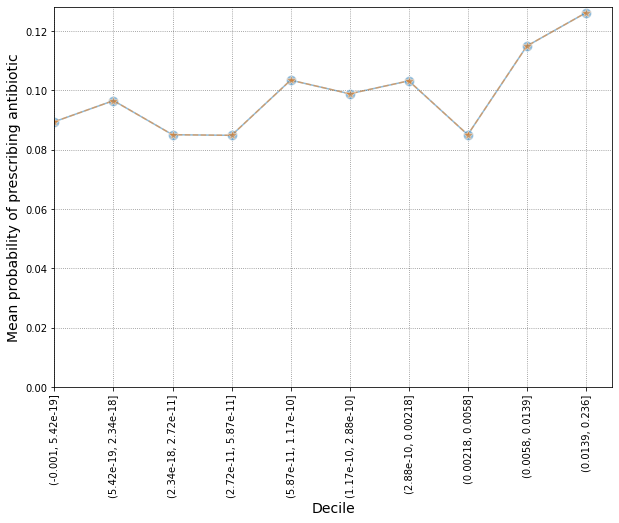


AUROC of LR for deciles with development and validation data: 0.55188 and 0.47205
LR ORs:
                                coef  coef_lower  coef_upper       ors  \
bins_(0.00218, 0.0058]    -0.111549   -0.146386   -0.076713  0.894447   
bins_(0.0058, 0.0139]      0.239889    0.204098    0.275680  1.271108   
bins_(0.0139, 0.236]       0.318810    0.284755    0.352865  1.375490   
bins_(1.17e-10, 2.88e-10] -0.138618   -0.173618   -0.103619  0.870560   
bins_(2.34e-18, 2.72e-11] -0.269980   -0.304085   -0.235874  0.763395   
bins_(2.72e-11, 5.87e-11] -0.088762   -0.123384   -0.054139  0.915064   
bins_(2.88e-10, 0.00218]   0.183642    0.148751    0.218532  1.201585   
bins_(5.42e-19, 2.34e-18]  0.047247    0.013092    0.081403  1.048381   
bins_(5.87e-11, 1.17e-10] -0.078967   -0.113750   -0.044184  0.924070   

                           ors_lower  ors_upper  
bins_(0.00218, 0.0058]      0.863824   0.926156  
bins_(0.0058, 0.0139]       1.226418   1.317426  
bins_(0.0139, 0.236]       

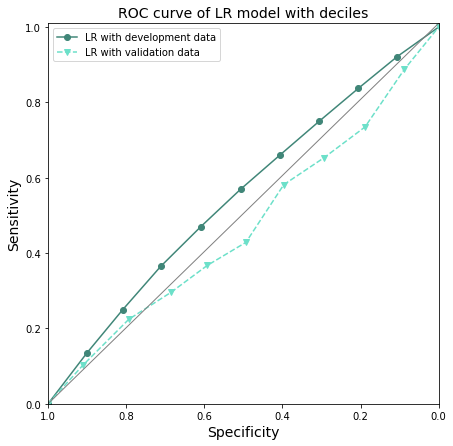

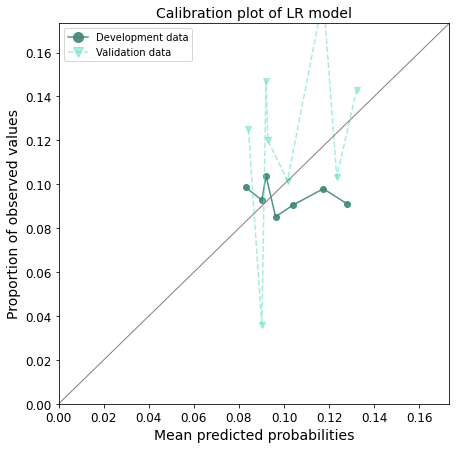

In [45]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl_during_pandemic, prob_pred_sinusitis_no_abs_prevl_during_pandemic_bin = cox_build('sinusitis', 'prevl_during_pandemic', data_sinusitis_prevl_during_pandemic, data_sinusitis_no_abs_prevl_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('sinusitis', 'prevl_during_pandemic_deciles', prob_pred_sinusitis_no_abs_prevl_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('sinusitis', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic)#, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 5040 total observations, 5002 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 5040
number of events observed = 38
   partial log-likelihood = -299.56
         time fit was run = 2023-07-30 22:35:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.10       0.90       0.44            -0.97             0.76                 0.38                 2.15
CCI_cat[T.medium]               -0.21       0.81       0.50            -1.20             0.77                 0.30                 2.17
CCI_cat[T.high]                 -0.94       0.39       0.79            -2.50             0.61                 0.08                 1.85
CCI_cat[T.very_high]            -0.52       0.60       0.58            -1.65             0.61                 0.19                 1.84
age_cat[T.25_34]                 1.28       3.59       0.65            -0.01             2.56                 0.99                12.94
age_cat[T.35_44]                -0.15       0.86       0.82            -1.76             1.46                 0.17                 4.32
age_cat[T.45_54]                -0.10       0.91       0.82            -1.70             1.51                 0.18                 4.53
age_cat[T.55_64]                 1.12       3.08       0.68            -0.21             2.46                 0.81                11.70
age_cat[T.65_74]                -0.47       0.62       0.92            -2.27             1.32                 0.10                 3.75
age_cat[T.75_more]               0.94       2.55       0.68            -0.40             2.27                 0.67                 9.65
antibacterial_brit              -0.15       0.86       0.12            -0.39             0.09                 0.68                 1.10
bmi_cat[T.obese]                -0.63       0.53       0.57            -1.74             0.48                 0.18                 1.62
bmi_cat[T.overweight]            0.32       1.37       0.63            -0.92             1.56                 0.40                 4.75
bmi_cat[T.underweight]           0.39       1.48       0.78            -1.13             1.91                 0.32                 6.75
bmi_cat[T.unknown]              -0.56       0.57       0.62            -1.77             0.66                 0.17                 1.93
ethnicity[T.other]               0.46       1.58       0.66            -0.83             1.74                 0.44                 5.70
ethnicity[T.unknown]            -0.57       0.56       0.62            -1.78             0.64                 0.17                 1.90
ethnicity[T.white]              -0.54       0.59       0.55            -1.62             0.55                 0.20                 1.74
flu_vaccine[T.yes]              -0.38       0.68       0.61            -1.57             0.81                 0.21                 2.24
imd[T.medium]                   -0.40       0.67       0.46            -1.31             0.51                 0.27                 1.66
imd[T.unaffluent]               -0.61       0.54       0.48            -1.55             0.33                 0.21                 1.40
imd[T.unknown]                  -1.01       0.36       1.05            -3.06             1.04                 0.05                 2.82
imd[T.very_affluent]            -1.20       0.30       0.58            -2.34            -0.06                 0.10                 0.94
imd[T.very_unaffluent]          -0.82       0.44       0.51            -1.81             0.17                 0.16                 1.18
region[T.east_midlands]          0.39       1.47       0.73    

13100


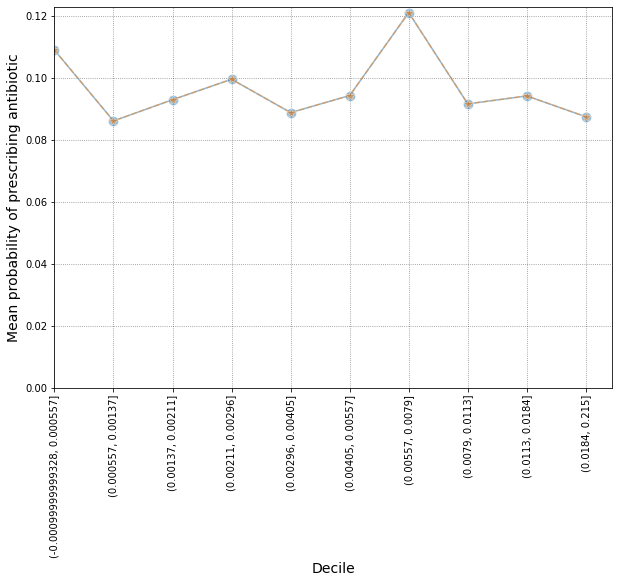


AUROC of LR for deciles with development and validation data: 0.52508 and 0.50884
LR ORs:
                               coef  coef_lower  coef_upper       ors  \
bins_(0.000557, 0.00137] -0.029176   -0.054968   -0.003385  0.971245   
bins_(0.00137, 0.00211]  -0.005449   -0.031526    0.020627  0.994566   
bins_(0.00211, 0.00296]  -0.054255   -0.079748   -0.028762  0.947190   
bins_(0.00296, 0.00405]  -0.032799   -0.058803   -0.006794  0.967733   
bins_(0.00405, 0.00557]   0.032684    0.006892    0.058475  1.033223   
bins_(0.00557, 0.0079]    0.275446    0.249793    0.301098  1.317117   
bins_(0.0079, 0.0113]    -0.027610   -0.053171   -0.002049  0.972768   
bins_(0.0113, 0.0184]     0.002671   -0.022534    0.027876  1.002675   
bins_(0.0184, 0.215]     -0.151138   -0.176791   -0.125485  0.859729   

                          ors_lower  ors_upper  
bins_(0.000557, 0.00137]   0.946515   0.996621  
bins_(0.00137, 0.00211]    0.968966   1.020842  
bins_(0.00211, 0.00296]    0.923349   0.

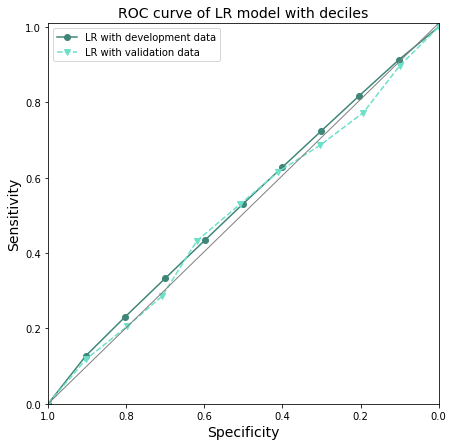

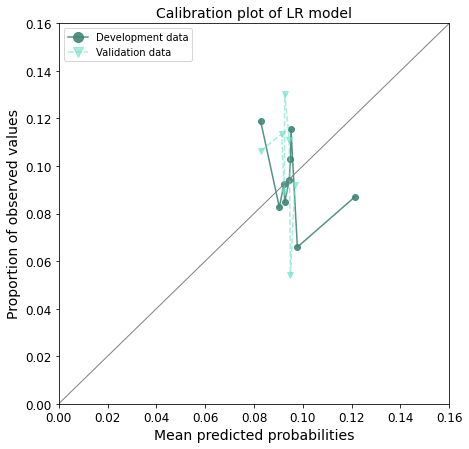

In [46]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl_post_2nd_lockdown, prob_pred_sinusitis_no_abs_prevl_post_2nd_lockdown_bin = cox_build('sinusitis', 'prevl_post_2nd_lockdown', data_sinusitis_prevl_post_2nd_lockdown, data_sinusitis_no_abs_prevl_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('sinusitis', 'prevl_post_2nd_lockdown_deciles', prob_pred_sinusitis_no_abs_prevl_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('sinusitis', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown)#, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")